<a href="https://colab.research.google.com/github/SamiCakiral/Manga-Image-Colorization/blob/main/Coloring_Manga_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎨 Manga Colorization with PyTorch



# Setup & Dataset

This cell handles the initial setup, imports all required libraries, and configures the dataset pipeline.

Key components:
- Basic configuration (paths, image sizes, training parameters)
- Dataset downloading and preprocessing
- GPU setup and optimization
- Data loading pipeline with custom transformations

In [2]:
#@title Imports & Configuration
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import zipfile
import gdown
from tqdm.auto import tqdm
import threading
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import cv2
import numpy as np
import shutil
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
import datetime
import copy

# @title 🛠️ Configuration and Setup

#@markdown ## Training Configuration
batch_size = 8 #@param {type:"slider", min:1, max:16, step:1}
epochs = 100 #@param {type:"slider", min:5, max:100, step:5}
learning_rate = 0.0004 #@param {type:"number"}
target_images = 100 #@param {type:"number"}

#@markdown ## Image Processing
target_size = 720 #@param {type:"slider", min:256, max:1024, step:128}
skip_start_pages = 6 # Skip the X first images of a Tome (frontpage etc)
skip_end_pages = 6 # Skip X last pages

#@markdown ## Hardware Settings
use_mixed_precision = True #@param {type:"boolean"}
num_workers = -1 #@param {type:"slider", min:-1, max:16, step:1}

#@markdown ## Dataset Source
gdrive_url = "https://drive.google.com/file/d/1-1OnmMgxGb-x19xTHACWVtrsRBT4Nezb/view?usp=share_link" #@param {type:"string"}
downloadDataset = False #@param {type:"boolean"}
class Config:
    """Configuration générale commune à tous les modèles"""
    # Chemins simplifiés
    BASE_PATH = "/content/colorization/"
    DATASET_PATH = "/content/dataset/"
    OUTPUT_DIR = "/content/models/"

    # Chemins pour MasterZipProcessor
    MASTER_ZIP_PATH = '/content/master.zip'
    CBZ_EXTRACT_PATH = '/content/cbz_files/'
    CHECKPOINT_DIR = "/content/checkpoints"

    # Configuration des images
    TARGET_SIZE = target_size

    # Configuration d'entraînement de base
    BATCH_SIZE = batch_size
    EPOCHS = epochs
    LEARNING_RATE = learning_rate
    NUM_WORKERS = multiprocessing.cpu_count() if num_workers == -1 else num_workers

    # Configuration du dataset
    TARGET_IMAGES = target_images
    GDRIVE_URL = gdrive_url
    SKIP_START_PAGES = skip_start_pages
    SKIP_END_PAGES = skip_end_pages

    # Configuration hardware
    USE_MIXED_PRECISION = use_mixed_precision

print("\n📊 Configuration actuelle:")
print(f"→ Batch size: {Config.BATCH_SIZE}")
print(f"→ Epochs: {Config.EPOCHS}")
print(f"→ Learning rate: {Config.LEARNING_RATE}")
print(f"→ Target size: {Config.TARGET_SIZE}x{Config.TARGET_SIZE}")
print(f"→ Target images: {Config.TARGET_IMAGES}")
print(f"→ Workers: {Config.NUM_WORKERS}")
print(f"→ Skip pages: {Config.SKIP_START_PAGES} start, {Config.SKIP_END_PAGES} end")
print(f"→ Mixed precision: {'✓' if Config.USE_MIXED_PRECISION else '✗'}")



📊 Configuration actuelle:
→ Batch size: 8
→ Epochs: 100
→ Learning rate: 0.0004
→ Target size: 720x720
→ Target images: 100
→ Workers: 2
→ Skip pages: 6 start, 6 end
→ Mixed precision: ✓


In [3]:
# @title Downloading and preparing Dataset
class MasterZipProcessor:
    def __init__(self):
        self.gdrive_url = Config.GDRIVE_URL
        self.master_zip_path = Config.MASTER_ZIP_PATH
        self.cbz_extract_path = Config.CBZ_EXTRACT_PATH

    def download_and_extract(self):
        """Télécharge et extrait le master zip"""
        print("📥 Téléchargement du master zip...")

        # Téléchargement avec gdown
        try:
            gdown.download(url=self.gdrive_url, output=self.master_zip_path, fuzzy=True, quiet=True)
        except Exception as e:
            print(f"❌ Erreur lors du téléchargement: {str(e)}")
            return False

        if not os.path.exists(self.master_zip_path):
            print("❌ Échec du téléchargement")
            return False

        print(f"✅ Téléchargement terminé: {os.path.getsize(self.master_zip_path) / 1024 / 1024:.2f} MB")

        # Extraction du master zip
        print("\n📦 Extraction des fichiers CBZ...")
        os.makedirs(self.cbz_extract_path, exist_ok=True)

        try:
            with zipfile.ZipFile(self.master_zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.cbz_extract_path)
            print("✅ Extraction terminée")

            # Nettoyage du zip
            os.remove(self.master_zip_path)
            return True

        except Exception as e:
            print(f"❌ Erreur lors de l'extraction: {str(e)}")
            return False

class DatasetCreator:
    def __init__(self, target_images=Config.TARGET_IMAGES):
        self.target_images = target_images
        self.image_counter = 0
        self.counter_lock = threading.Lock()
        self.stop_processing = False

        # Chemins
        self.cbz_path = Config.CBZ_EXTRACT_PATH
        self.temp_path = '/content/temp_cbz/'
        self.output_path = Config.DATASET_PATH

        # Créer les répertoires nécessaires
        os.makedirs(self.temp_path, exist_ok=True)
        os.makedirs(self.output_path, exist_ok=True)

        # Nombre de workers pour le traitement parallèle
        self.num_workers = Config.NUM_WORKERS

        # Barre de progression
        self.pbar = tqdm(total=target_images, desc="Images traitées")

    def process_single_image(self, args):
        """Traite une seule image depuis le dossier temporaire."""
        if self.stop_processing:
            return

        image_path, temp_dir = args
        try:
            # Lecture et prétraitement avec CV2
            img = cv2.imread(image_path)
            if img is None:
                return

            # Redimensionnement carré avec maintien du ratio
            h, w = img.shape[:2]
            ratio = Config.TARGET_SIZE / max(h, w)
            new_size = (int(w * ratio), int(h * ratio))
            img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

            # Padding pour image carrée
            delta_w = Config.TARGET_SIZE - new_size[0]
            delta_h = Config.TARGET_SIZE - new_size[1]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            img = cv2.copyMakeBorder(
                img, top, bottom, left, right,
                cv2.BORDER_CONSTANT,
                value=[255, 255, 255]
            )

            # Création ID unique
            with self.counter_lock:
                if self.image_counter >= self.target_images:
                    self.stop_processing = True
                    return
                image_id = f"image_{self.image_counter:05d}"
                self.image_counter += 1
                self.pbar.update(1)

            output_dir = os.path.join(self.output_path, image_id)
            os.makedirs(output_dir, exist_ok=True)

            # Sauvegarde version couleur
            cv2.imwrite(os.path.join(output_dir, 'color.png'), img)

            # Conversion et sauvegarde N&B
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(os.path.join(output_dir, 'bw.png'), gray)

        except Exception as e:
            print(f"Erreur lors du traitement de {image_path}: {str(e)}")

    def get_filtered_images(self, directory):
        """Récupère les images en ignorant les premières et dernières pages des chapitres."""
        chapters = {}

        for root, _, files in os.walk(directory):
            chapter_name = os.path.basename(root)
            if files:
                image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                if image_files:
                    image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
                    chapters[chapter_name] = [os.path.join(root, f) for f in image_files]

        filtered_images = []
        chapter_names = sorted(chapters.keys())

        for i, chapter in enumerate(chapter_names):
            images = chapters[chapter]
            if i == 0 or i == len(chapter_names) - 1:
                images = images[Config.SKIP_START_PAGES:-Config.SKIP_END_PAGES]
            filtered_images.extend((img, directory) for img in images)

        return filtered_images

    def extract_cbz(self, cbz_file):
        """Extrait le contenu d'un fichier CBZ dans un dossier temporaire."""
        temp_dir = os.path.join(self.temp_path, os.path.splitext(os.path.basename(cbz_file))[0])
        os.makedirs(temp_dir, exist_ok=True)

        try:
            with zipfile.ZipFile(cbz_file, 'r') as zip_ref:
                for file in zip_ref.namelist():
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        zip_ref.extract(file, temp_dir)
            return temp_dir
        except Exception as e:
            print(f"Erreur lors de l'extraction de {cbz_file}: {str(e)}")
            shutil.rmtree(temp_dir, ignore_errors=True)
            return None

    def process_cbz(self, cbz_file):
        """Traite un fichier CBZ."""
        temp_dir = self.extract_cbz(cbz_file)
        if not temp_dir:
            return

        try:
            image_files = self.get_filtered_images(temp_dir)
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                list(executor.map(self.process_single_image, image_files))
        finally:
            shutil.rmtree(temp_dir, ignore_errors=True)

    def create_dataset(self):
        """Crée le dataset avec le nombre d'images spécifié."""
        print(f"\nCréation d'un dataset avec {self.target_images} images...")

        cbz_files = [os.path.join(self.cbz_path, f)
                    for f in os.listdir(self.cbz_path)
                    if f.lower().endswith('.cbz')]

        for cbz_file in tqdm(cbz_files, desc="Traitement des tomes"):
            if self.stop_processing:
                break
            self.process_cbz(cbz_file)

        self.pbar.close()

        # Nettoyage final
        shutil.rmtree(self.cbz_path, ignore_errors=True)
        return self.image_counter

class MangaDataset(Dataset):
    """Dataset PyTorch pour les images manga"""
    def __init__(self, data_dir=Config.DATASET_PATH, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_pairs = []
        self._scan_images()

    def _scan_images(self):
        print("\n📁 Scan des images...")
        for img_dir in tqdm(os.listdir(self.data_dir)):
            full_path = os.path.join(self.data_dir, img_dir)
            if os.path.isdir(full_path):
                bw_path = os.path.join(full_path, "bw.png")
                color_path = os.path.join(full_path, "color.png")
                if os.path.exists(bw_path) and os.path.exists(color_path):
                    self.image_pairs.append((bw_path, color_path))
        print(f"✓ Trouvé {len(self.image_pairs)} paires d'images")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        bw_path, color_path = self.image_pairs[idx]

        # Chargement avec CV2
        bw_img = cv2.imread(bw_path, cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(color_path)

        # Conversion BGR -> RGB
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

        # Normalisation [-1, 1]
        bw_tensor = torch.from_numpy(bw_img).float() / 127.5 - 1
        color_tensor = torch.from_numpy(color_img).float().permute(2, 0, 1) / 127.5 - 1

        # Ajout dimension canal pour bw
        bw_tensor = bw_tensor.unsqueeze(0)

        if self.transform:
            bw_tensor = self.transform(bw_tensor)
            color_tensor = self.transform(color_tensor)

        return bw_tensor, color_tensor

def setup_gpu():
    """Configure le GPU pour des performances optimales"""
    print("\n💻 Configuration hardware:")
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

        device = torch.device("cuda")
        torch.cuda.empty_cache()

        print(f"✓ GPU détecté: {torch.cuda.get_device_name()}")
        print(f"✓ Mémoire totale: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f}GB")
        print("✓ TF32 activé")
        print("✓ CUDNN benchmark activé")
        return device
    else:
        print("⚠️ Aucun GPU détecté, utilisation du CPU")
        return torch.device("cpu")

# Préparation du dataset
zip_processor = MasterZipProcessor()
if downloadDataset :
  if zip_processor.download_and_extract():
      creator = DatasetCreator()
      creator.create_dataset()
  # Création du dataset PyTorch
  dataset = MangaDataset()

else :
  print("\nNo Dataset Downloaded as requiered")
  dataset = MangaDataset()

# Création du DataLoader
dataloader = DataLoader(
      dataset,
      batch_size=Config.BATCH_SIZE,
      shuffle=True,
      num_workers=Config.NUM_WORKERS,
      pin_memory=True
  )

# Configuration du GPU
device = setup_gpu()




No Dataset Downloaded as requiered

📁 Scan des images...


  0%|          | 0/100 [00:00<?, ?it/s]

✓ Trouvé 100 paires d'images

💻 Configuration hardware:
✓ GPU détecté: Tesla T4
✓ Mémoire totale: 15.8GB
✓ TF32 activé
✓ CUDNN benchmark activé


# Training

Common features across all models:
- Learning rate scheduling
- Gradient clipping
- Mixed precision training
- Checkpoint management
- Early stopping

Model-specific training features:
- **U-Net/ResUNet**: Standard supervised training
- **VAE**: KL divergence balancing
- **GAN**: Adversarial and reconstruction losses
- **Diffusion**: Progressive denoising steps

---

## Models

Choose your model architecture from our collection of state-of-the-art approaches and their parameters:

Available models:
- **U-Net**: Classic architecture with skip connections
- **ResUNet**: Enhanced U-Net with residual blocks
- **VAE**: Variational autoencoder for controlled generation
- **GAN**: Adversarial approach for realistic colorization
- **Diffusion**: Progressive denoising process

In [4]:
# @title 🔧 Configuration U-Net
import torch
import torch.nn as nn
import torch.nn.functional as F

#@markdown ### Architecture du U-Net
n_filters = "16,32,64,128,256" #@param {type:"string"}
dropout_min = 0.1 #@param {type:"slider", min:0.0, max:0.3, step:0.05}
dropout_max = 0.3 #@param {type:"slider", min:0.1, max:0.5, step:0.05}
use_batch_norm = True #@param {type:"boolean"}
activation = 'LeakyReLU' #@param ["ReLU", "LeakyReLU", "ELU"]
leaky_slope = 0.2 #@param {type:"slider", min:0.01, max:0.5, step:0.01}

class UNetConfig:
    """Configuration spécifique pour U-Net"""
    def __init__(self):
        # Architecture
        self.FILTERS = [int(f) for f in n_filters.split(',')]
        self.CHANNELS = self.FILTERS[0]  # Premier niveau de filtres
        self.DROPOUT_MIN = dropout_min
        self.DROPOUT_MAX = dropout_max
        self.USE_BATCH_NORM = use_batch_norm
        self.ACTIVATION = activation
        self.LEAKY_SLOPE = leaky_slope

        # Configuration d'entraînement
        self.LEARNING_RATE = Config.LEARNING_RATE
        self.BATCH_SIZE = Config.BATCH_SIZE
        self.NUM_WORKERS = Config.NUM_WORKERS

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_rate=0.1, config=None):
        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        ]

        if config.USE_BATCH_NORM:
            layers.append(nn.BatchNorm2d(out_channels))

        # Activation function
        if config.ACTIVATION == 'LeakyReLU':
            layers.append(nn.LeakyReLU(config.LEAKY_SLOPE, inplace=True))
        elif config.ACTIVATION == 'ELU':
            layers.append(nn.ELU(inplace=True))
        else:
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Dropout2d(dropout_rate))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Encoder
        self.encoder_blocks = nn.ModuleList()
        in_channels = 1  # Image N&B
        for i, f in enumerate(config.FILTERS):
            dropout_rate = min(config.DROPOUT_MIN + i * 0.05, config.DROPOUT_MAX)
            block = nn.Sequential(
                ConvBlock(in_channels, f, dropout_rate=dropout_rate, config=config),
                ConvBlock(f, f, dropout_rate=dropout_rate, config=config)
            )
            self.encoder_blocks.append(block)
            in_channels = f

        # Bridge
        self.bridge = nn.Sequential(
            ConvBlock(config.FILTERS[-1], config.FILTERS[-1]*2, dropout_rate=config.DROPOUT_MAX, config=config),
            ConvBlock(config.FILTERS[-1]*2, config.FILTERS[-1]*2, dropout_rate=config.DROPOUT_MAX, config=config)
        )

        # Decoder
        self.decoder_blocks = nn.ModuleList()
        in_channels = config.FILTERS[-1]*2
        for i, f in enumerate(reversed(config.FILTERS)):
            dropout_rate = max(config.DROPOUT_MAX - i * 0.05, config.DROPOUT_MIN)
            block = nn.Sequential(
                ConvBlock(in_channels + f, f, dropout_rate=dropout_rate, config=config),
                ConvBlock(f, f, dropout_rate=dropout_rate, config=config)
            )
            self.decoder_blocks.append(block)
            in_channels = f

        # Final layer avec moins de filtres pour réduire la mémoire
        self.final = nn.Sequential(
            ConvBlock(config.FILTERS[0], 32, dropout_rate=config.DROPOUT_MIN, config=config),
            ConvBlock(32, 16, dropout_rate=config.DROPOUT_MIN, config=config),
            nn.Conv2d(16, 3, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        encoder_features = []
        for block in self.encoder_blocks:
            x = block(x)
            encoder_features.append(x)
            x = F.max_pool2d(x, 2)

        # Bridge
        x = self.bridge(x)

        # Decoder
        for block, skip in zip(self.decoder_blocks, reversed(encoder_features)):
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = torch.cat([x, skip], dim=1)
            x = block(x)

        return self.final(x)

# Création de la configuration
unet_config = UNetConfig()

print("\n✨ Configuration U-Net optimisée:")
print(f"→ Filtres: {unet_config.FILTERS}")
print(f"→ Channels de base: {unet_config.CHANNELS}")
print(f"→ Dropout: {unet_config.DROPOUT_MIN} - {unet_config.DROPOUT_MAX}")
print(f"→ Batch Norm: {'✓' if unet_config.USE_BATCH_NORM else '✗'}")
print(f"→ Activation: {unet_config.ACTIVATION}")
if unet_config.ACTIVATION == 'LeakyReLU':
    print(f"→ Leaky slope: {unet_config.LEAKY_SLOPE}")


✨ Configuration U-Net optimisée:
→ Filtres: [16, 32, 64, 128, 256]
→ Channels de base: 16
→ Dropout: 0.1 - 0.3
→ Batch Norm: ✓
→ Activation: LeakyReLU
→ Leaky slope: 0.2


In [5]:
# @title 🔧 Configuration ResUNet

#@markdown ### Architecture du ResUNet
n_filters = "64,128,256,512,1024" #@param {type:"string"}
use_attention = True #@param {type:"boolean"}
dropout_rate = 0.1 #@param {type:"slider", min:0.0, max:0.5, step:0.1}

#@markdown ### Configuration des blocs résiduels
residual_scaling = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
use_preactivation = True #@param {type:"boolean"}
use_se_blocks = True #@param {type:"boolean"}

class ResUNetConfig:
    """Configuration spécifique pour ResUNet"""
    def __init__(self):
        self.FILTERS = [int(f) for f in n_filters.split(',')]
        self.USE_ATTENTION = use_attention
        self.DROPOUT_RATE = dropout_rate
        self.RESIDUAL_SCALING = residual_scaling
        self.USE_PREACTIVATION = use_preactivation
        self.USE_SE_BLOCKS = use_se_blocks

        # Configuration d'entraînement spécifique
        self.LEARNING_RATE = Config.LEARNING_RATE
        self.BATCH_SIZE = Config.BATCH_SIZE
        self.NUM_WORKERS = Config.NUM_WORKERS

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        s = self.squeeze(x).view(b, c)
        s = self.excitation(s).view(b, c, 1, 1)
        return x * s.expand_as(x)

class ResBlock(nn.Module):
    """Bloc résiduel amélioré"""
    def __init__(self, in_channels, out_channels, config):
        super().__init__()
        self.use_se = config.USE_SE_BLOCKS
        self.scaling = config.RESIDUAL_SCALING
        self.preactivation = config.USE_PREACTIVATION

        # Couches principales
        if self.preactivation:
            self.block = nn.Sequential(
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels)
            )

        # Squeeze-and-Excitation
        self.se = SEBlock(out_channels) if self.use_se else None

        # Connexion résiduelle
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.block(x)

        if self.se:
            out = self.se(out)

        out = out * self.scaling + residual

        if not self.preactivation:
            out = F.relu(out)

        return out

class ResUNet(nn.Module):
    """U-Net avec blocs résiduels améliorés"""
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Encoder
        self.encoder = nn.ModuleList()
        in_channels = 1
        for f in config.FILTERS:
            self.encoder.append(
                nn.Sequential(
                    ResBlock(in_channels, f, config),
                    nn.Dropout2d(config.DROPOUT_RATE)
                )
            )
            in_channels = f

        # Bridge avec attention si activé
        self.bridge = ResBlock(config.FILTERS[-1], config.FILTERS[-1]*2, config)
        if config.USE_ATTENTION:
            self.attention = SelfAttention(config.FILTERS[-1]*2)

        # Decoder
        self.decoder = nn.ModuleList()
        filters = config.FILTERS[::-1]  # Reverse
        in_channels = filters[0]*2

        for f in filters:
            self.decoder.append(nn.Sequential(
                nn.ConvTranspose2d(in_channels, f, 2, stride=2),
                ResBlock(f*2, f, config),  # *2 car concat avec skip
                nn.Dropout2d(config.DROPOUT_RATE)
            ))
            in_channels = f

        # Output
        self.final = nn.Sequential(
            nn.Conv2d(filters[-1], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 1),
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        skips = []
        for block in self.encoder:
            x = block(x)
            skips.append(x)
            x = F.max_pool2d(x, 2)

        # Bridge
        x = self.bridge(x)
        if self.config.USE_ATTENTION:
            x = self.attention(x)

        # Decoder
        skips = skips[::-1]  # Reverse
        for i, block in enumerate(self.decoder):
            x = block[0](x)  # Upsampling
            x = torch.cat([x, skips[i]], dim=1)  # Skip connection
            x = block[1:](x)  # ResBlock + Dropout

        return self.final(x)

class SelfAttention(nn.Module):
    """Module d'auto-attention"""
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        # Projections
        proj_query = self.query(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, width*height)
        proj_value = self.value(x).view(batch_size, -1, width*height)

        # Attention map
        attention = torch.bmm(proj_query, proj_key)
        attention = F.softmax(attention, dim=2)

        # Output
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return x + self.gamma * out

# Création de la configuration
resunet_config = ResUNetConfig()

print("\n✨ Configuration ResUNet:")
print(f"→ Filtres: {resunet_config.FILTERS}")
print(f"→ Attention: {'✓' if resunet_config.USE_ATTENTION else '✗'}")
print(f"→ Dropout: {resunet_config.DROPOUT_RATE}")
print(f"→ SE Blocks: {'✓' if resunet_config.USE_SE_BLOCKS else '✗'}")


✨ Configuration ResUNet:
→ Filtres: [64, 128, 256, 512, 1024]
→ Attention: ✓
→ Dropout: 0.1
→ SE Blocks: ✓


In [6]:
# @title 🔧 Configuration VAE

#@markdown ### Architecture de base
n_filters = "32,64,128,256" #@param {type:"string"}
latent_dim = 256 #@param {type:"integer"}
beta = 1.0 #@param {type:"slider", min:0.1, max:5.0, step:0.1}

#@markdown ### Configuration avancée
use_residual = True #@param {type:"boolean"}
use_spectral_norm = False #@param {type:"boolean"}
kl_weight = 0.01 #@param {type:"slider", min:0.001, max:0.1, step:0.001}
use_perceptual_loss = False #@param {type:"boolean"}

class VAEConfig:
    """Configuration spécifique pour VAE"""
    def __init__(self):
        self.FILTERS = [int(f) for f in n_filters.split(',')]
        self.LATENT_DIM = latent_dim
        self.BETA = beta  # Poids du terme KL
        self.USE_RESIDUAL = use_residual
        self.USE_SPECTRAL_NORM = use_spectral_norm
        self.KL_WEIGHT = kl_weight
        self.USE_PERCEPTUAL_LOSS = use_perceptual_loss

class ResidualBlock(nn.Module):
    """Bloc résiduel pour le VAE"""
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class VAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Vérification de la taille d'entrée
        if Config.TARGET_SIZE % (2 ** len(config.FILTERS)) != 0:
            raise ValueError(f"La taille d'image {Config.TARGET_SIZE} n'est pas compatible avec {len(config.FILTERS)} couches")

        # Encoder
        encoder_layers = []
        in_channels = 1  # Image noir et blanc
        for f in config.FILTERS:
            if config.USE_SPECTRAL_NORM:
                encoder_layers.extend([
                    nn.utils.spectral_norm(nn.Conv2d(in_channels, f, 4, stride=2, padding=1)),
                    nn.LeakyReLU(0.2, inplace=True)
                ])
            else:
                encoder_layers.extend([
                    nn.Conv2d(in_channels, f, 4, stride=2, padding=1),
                    nn.BatchNorm2d(f),
                    nn.LeakyReLU(0.2, inplace=True)
                ])
            if config.USE_RESIDUAL:
                encoder_layers.append(ResidualBlock(f))
            in_channels = f

        self.encoder = nn.Sequential(*encoder_layers)

        # Calculate feature size and dimensions after encoder
        with torch.no_grad():
            test_input = torch.zeros(1, 1, Config.TARGET_SIZE, Config.TARGET_SIZE)
            test_output = self.encoder(test_input)
            self.encoded_channels = test_output.size(1)  # 256 (dernier filtre)
            self.encoded_height = test_output.size(2)    # 720/16 = 45
            self.encoded_width = test_output.size(3)     # 720/16 = 45
            self.feature_size = test_output.view(1, -1).size(1)

        # Latent space
        self.fc_mu = nn.Linear(self.feature_size, config.LATENT_DIM)
        self.fc_var = nn.Linear(self.feature_size, config.LATENT_DIM)
        self.fc_decode = nn.Linear(config.LATENT_DIM, self.feature_size)

        # Decoder
        decoder_layers = []
        reversed_filters = list(reversed(config.FILTERS))
        in_channels = reversed_filters[0]

        for i, f in enumerate(reversed_filters[1:], 1):
            if config.USE_SPECTRAL_NORM:
                decoder_layers.extend([
                    nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, f, 4, stride=2, padding=1)),
                    nn.LeakyReLU(0.2, inplace=True)
                ])
            else:
                decoder_layers.extend([
                    nn.ConvTranspose2d(in_channels, f, 4, stride=2, padding=1),
                    nn.BatchNorm2d(f),
                    nn.LeakyReLU(0.2, inplace=True)
                ])
            if config.USE_RESIDUAL:
                decoder_layers.append(ResidualBlock(f))
            in_channels = f

        # Final layers
        decoder_layers.extend([
            nn.ConvTranspose2d(in_channels, 3, 4, stride=2, padding=1),  # Sortie en RGB
            nn.Tanh()
        ])

        self.decoder = nn.Sequential(*decoder_layers)

        # Vérification de la symétrie encoder-decoder
        with torch.no_grad():
            z = torch.zeros(1, config.LATENT_DIM)
            test_decode = self.fc_decode(z).view(1, self.encoded_channels,
                                               self.encoded_height, self.encoded_width)
            final_output = self.decoder(test_decode)
            if final_output.size() != torch.Size([1, 3, Config.TARGET_SIZE, Config.TARGET_SIZE]):
                raise ValueError(f"Dimensions de sortie incorrectes: obtenu {final_output.size()}, "
                              f"attendu [1, 3, {Config.TARGET_SIZE}, {Config.TARGET_SIZE}]")

    def encode(self, x):
        if x.size(1) != 1:
            raise ValueError("L'entrée doit avoir 1 canal (noir et blanc)")

        # Normalisation explicite
        x = (x - x.mean()) / (x.std() + 1e-8)

        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        # Contraintes sur mu et log_var
        mu = self.fc_mu(x)
        mu = torch.clamp(mu, min=-10, max=10)  # Limite les valeurs extrêmes

        log_var = self.fc_var(x)
        log_var = torch.clamp(log_var, min=-20, max=2)  # Évite exp(log_var) trop grand/petit

        return mu, log_var

    def reparameterize(self, mu, log_var):
        if torch.isnan(mu).any() or torch.isnan(log_var).any():
            raise ValueError("NaN détecté dans mu ou log_var")

        # Limiter la variance pour éviter l'explosion
        std = torch.exp(0.5 * torch.clamp(log_var, min=-20, max=2))
        std = torch.clamp(std, min=1e-8, max=10)

        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        try:
            z = z.view(z.size(0), self.encoded_channels, self.encoded_height, self.encoded_width)
        except RuntimeError:
            raise ValueError(f"Impossible de reshape z en {self.encoded_channels}x{self.encoded_height}x{self.encoded_width}")
        return self.decoder(z)

    def forward(self, x):
        if x.size(1) != 1:
            raise ValueError("L'entrée doit avoir 1 canal (noir et blanc)")
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        output = self.decode(z)
        if output.size(1) != 3:
            raise ValueError("La sortie doit avoir 3 canaux (RGB)")
        return output, mu, log_var

class VAELoss(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.reconstruction_loss = nn.MSELoss(reduction='mean')
        self.kl_weight = 0.0001  # Commencer très petit
        self.warmup = 0  # Pour progressive KL annealing

    def forward(self, recon_x, x, mu, log_var, batch_size):
        if recon_x.size(1) != 3:
            raise ValueError("recon_x doit être RGB (3 canaux)")
        if x.size(1) != 1:
            raise ValueError("x doit être noir et blanc (1 canal)")

        # Normaliser les entrées
        x_expanded = x.repeat(1, 3, 1, 1)
        x_expanded = (x_expanded - x_expanded.mean()) / (x_expanded.std() + 1e-8)
        recon_x = (recon_x - recon_x.mean()) / (recon_x.std() + 1e-8)

        # Reconstruction loss avec scaling
        recon_loss = self.reconstruction_loss(recon_x, x_expanded)

        # KL loss avec safeguards
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        kl_loss = torch.clamp(kl_loss, min=0, max=100)  # Évite les valeurs extrêmes

        # Progressive KL annealing
        self.warmup = min(1.0, self.warmup + 0.001)
        kl_weight = self.kl_weight * self.warmup

        # Total loss avec meilleur scaling
        loss = recon_loss + kl_weight * kl_loss

        return loss, {
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'total_loss': loss.item()
        }

# Création de la configuration
vae_config = VAEConfig()

print("\n✨ Configuration VAE:")
print(f"→ Architecture: {vae_config.FILTERS}")
print(f"→ Dimension latente: {vae_config.LATENT_DIM}")
print(f"→ Beta: {vae_config.BETA}")
print(f"→ Blocs résiduels: {'✓' if vae_config.USE_RESIDUAL else '✗'}")
print(f"→ Normalisation spectrale: {'✓' if vae_config.USE_SPECTRAL_NORM else '✗'}")
print(f"→ Poids KL: {vae_config.KL_WEIGHT}")
print(f"→ Perte perceptuelle: {'✓' if vae_config.USE_PERCEPTUAL_LOSS else '✗'}")


✨ Configuration VAE:
→ Architecture: [32, 64, 128, 256]
→ Dimension latente: 256
→ Beta: 1.0
→ Blocs résiduels: ✓
→ Normalisation spectrale: ✗
→ Poids KL: 0.01
→ Perte perceptuelle: ✗


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

# @title 🔧 Configuration GAN

#@markdown ### Architecture du Générateur
g_filters = "32,64,128,256" #@param {type:"string"}
g_use_attention = True #@param {type:"boolean"}
g_use_residual = True #@param {type:"boolean"}

#@markdown ### Architecture du Discriminateur
d_filters = "32,64,128,256" #@param {type:"string"}
patch_size = 70 #@param {type:"slider", min:16, max:256, step:2}
use_spectral_norm = True #@param {type:"boolean"}

#@markdown ### Configuration de l'entraînement
gan_mode = 'lsgan' #@param ["vanilla", "lsgan", "wgan-gp"]
lambda_L1 = 100 #@param {type:"integer"}
use_historical_averaging = True #@param {type:"boolean"}
buffer_size = 50 #@param {type:"integer"}

class GANConfig:
    """Configuration spécifique pour GAN"""
    def __init__(self):
        # Architecture
        self.G_FILTERS = [int(f) for f in g_filters.split(',')]
        self.D_FILTERS = [int(f) for f in d_filters.split(',')]
        self.CHANNELS = self.G_FILTERS[0]  # Pour compatibilité avec select_model

        # Options du générateur
        self.G_USE_ATTENTION = g_use_attention
        self.G_USE_RESIDUAL = g_use_residual

        # Options du discriminateur
        self.PATCH_SIZE = patch_size
        self.USE_SPECTRAL_NORM = use_spectral_norm

        # Options d'entraînement
        self.GAN_MODE = gan_mode
        self.LAMBDA_L1 = lambda_L1
        self.USE_HISTORICAL_AVG = use_historical_averaging
        self.BUFFER_SIZE = buffer_size

        # Configuration commune
        self.LEARNING_RATE = Config.LEARNING_RATE
        self.BATCH_SIZE = Config.BATCH_SIZE
        self.NUM_WORKERS = Config.NUM_WORKERS

class SelfAttention(nn.Module):
    """Module d'attention pour les features maps"""
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv2d(in_channels, in_channels//8, 1)
        self.key = nn.Conv2d(in_channels, in_channels//8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
        x: tensor de features [B, C, H, W]
        retourne: tensor avec attention appliquée
        """
        batch_size, C, width, height = x.size()

        # Calcul des projections Q, K, V
        proj_query = self.query(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key(x).view(batch_size, -1, width*height)
        attention = torch.bmm(proj_query, proj_key)
        attention = F.softmax(attention, dim=-1)

        proj_value = self.value(x).view(batch_size, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        # Connexion résiduelle avec facteur d'échelle appris
        return x + self.gamma * out

class ResidualBlock(nn.Module):
    """Bloc résiduel avec normalisation par lots"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + residual
        return F.relu(out)

class Generator(nn.Module):
    """Générateur basé sur un U-Net avec attention"""
    def __init__(self, config):
        super().__init__()

        # Encoder
        model = []
        in_channels = 1  # Image N&B en entrée

        for f in config.G_FILTERS:
            # Couche de convolution avec normalisation spectrale optionnelle
            conv = nn.Conv2d(in_channels, f, 4, stride=2, padding=1)
            if config.USE_SPECTRAL_NORM:
                conv = nn.utils.spectral_norm(conv)

            model += [
                conv,
                nn.BatchNorm2d(f),
                nn.LeakyReLU(0.2, True)
            ]

            # Ajout du bloc d'attention pour les features maps larges
            if config.G_USE_ATTENTION and f >= 128:
                model += [SelfAttention(f)]

            in_channels = f

        # Blocs résiduels au goulot d'étranglement
        if config.G_USE_RESIDUAL:
            for _ in range(4):  # Réduit de 6 à 4 pour optimiser la mémoire
                model.append(ResidualBlock(in_channels))

        # Decoder avec skip connections implicites
        for f in reversed(config.G_FILTERS[:-1]):
            # Couche de déconvolution
            deconv = nn.ConvTranspose2d(in_channels, f, 4, stride=2, padding=1)
            if config.USE_SPECTRAL_NORM:
                deconv = nn.utils.spectral_norm(deconv)

            model += [
                deconv,
                nn.BatchNorm2d(f),
                nn.ReLU(True)
            ]

            # Attention dans le décodeur aussi
            if config.G_USE_ATTENTION and f >= 128:
                model += [SelfAttention(f)]

            in_channels = f

        # Couche finale
        model += [
            nn.ConvTranspose2d(in_channels, 3, 4, stride=2, padding=1),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    """Discriminateur PatchGAN"""
    def __init__(self, config):
        super().__init__()

        model = []
        in_channels = 4  # RGB + Grayscale

        for f in config.D_FILTERS:
            conv = nn.Conv2d(in_channels, f, 4, stride=2, padding=1)
            if config.USE_SPECTRAL_NORM:
                conv = nn.utils.spectral_norm(conv)

            model += [
                conv,
                nn.LeakyReLU(0.2, True)
            ]

            # Attention pour les features maps profondes
            if f >= 128:
                model += [SelfAttention(f)]

            in_channels = f

        # Classificateur final PatchGAN
        final_conv = nn.Conv2d(in_channels, 1, 4, padding=1)
        if config.USE_SPECTRAL_NORM:
            final_conv = nn.utils.spectral_norm(final_conv)

        model.append(final_conv)
        self.model = nn.Sequential(*model)

    def forward(self, color, gray):
        x = torch.cat([color, gray], dim=1)
        return self.model(x)

class GANLoss(nn.Module):
    """Gestion des différents types de pertes GAN"""
    def __init__(self, gan_mode='lsgan'):
        super().__init__()
        self.gan_mode = gan_mode
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'wgan-gp':
            self.loss = None
        else:
            raise NotImplementedError(f'Mode GAN {gan_mode} non supporté')

    def __call__(self, prediction, target_is_real):
        if self.gan_mode in ['lsgan', 'vanilla']:
            target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
            return self.loss(prediction, target)
        elif self.gan_mode == 'wgan-gp':
            return -prediction.mean() if target_is_real else prediction.mean()

class ImageBuffer:
    """Buffer pour la stabilisation de l'entraînement"""
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def query(self, images):
        if self.buffer_size == 0:
            return images

        return_images = []
        for image in images:
            if len(self.buffer) < self.buffer_size:
                self.buffer.append(image.clone())
                return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.buffer_size-1)
                    return_images.append(self.buffer[idx].clone())
                    self.buffer[idx] = image.clone()
                else:
                    return_images.append(image)

        return torch.stack(return_images)

class GANModel(nn.Module):
    """Modèle GAN complet avec générateur et discriminateur"""
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Sous-réseaux
        self.generator = Generator(config)
        self.discriminator = Discriminator(config)

        # Fonctions de perte
        self.criterion_gan = GANLoss(gan_mode=config.GAN_MODE)
        self.criterion_l1 = nn.L1Loss()

        # Buffer pour l'historical averaging
        if config.USE_HISTORICAL_AVG:
            self.fake_buffer = ImageBuffer(config.BUFFER_SIZE)

    def forward(self, x):
        """Pour l'inférence, on utilise uniquement le générateur"""
        return self.generator(x)

    def setup_optimizers(self, lr):
        """Initialise les optimiseurs pour G et D"""
        self.optimizer_G = optim.Adam(
            self.generator.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )
        self.optimizer_D = optim.Adam(
            self.discriminator.parameters(),
            lr=lr,
            betas=(0.5, 0.999)
        )

    def train_discriminator(self, real_color, gray):
        """Une étape d'entraînement du discriminateur"""
        # Génère une image colorée
        fake_color = self.generator(gray)

        # Utilise le buffer si activé
        if self.config.USE_HISTORICAL_AVG:
            fake_color = self.fake_buffer.query(fake_color)

        # Perte sur les fausses images
        pred_fake = self.discriminator(fake_color.detach(), gray)
        loss_D_fake = self.criterion_gan(pred_fake, False)

        # Perte sur les vraies images
        pred_real = self.discriminator(real_color, gray)
        loss_D_real = self.criterion_gan(pred_real, True)

        # Perte totale
        loss_D = (loss_D_fake + loss_D_real) * 0.5
        return loss_D, fake_color

    def train_generator(self, real_color, gray, fake_color):
        """Une étape d'entraînement du générateur"""
        # Perte adversariale
        pred_fake = self.discriminator(fake_color, gray)
        loss_G_gan = self.criterion_gan(pred_fake, True)

        # Perte L1
        loss_G_L1 = self.criterion_l1(fake_color, real_color) * self.config.LAMBDA_L1

        # Perte totale
        loss_G = loss_G_gan + loss_G_L1
        return loss_G, {
            'gan': loss_G_gan.item(),
            'l1': loss_G_L1.item()
        }

# Création de la configuration
gan_config = GANConfig()

print("\n✨ Configuration GAN optimisée:")
print(f"→ Générateur: {gan_config.G_FILTERS}")
print(f"→ Discriminateur: {gan_config.D_FILTERS}")
print(f"→ Attention: {'✓' if gan_config.G_USE_ATTENTION else '✗'}")
print(f"→ Blocs résiduels: {'✓' if gan_config.G_USE_RESIDUAL else '✗'}")
print(f"→ Mode GAN: {gan_config.GAN_MODE}")
print(f"→ Taille patch: {gan_config.PATCH_SIZE}")
print(f"→ Normalisation spectrale: {'✓' if gan_config.USE_SPECTRAL_NORM else '✗'}")
print(f"→ Historical averaging: {'✓' if gan_config.USE_HISTORICAL_AVG else '✗'}")


✨ Configuration GAN optimisée:
→ Générateur: [32, 64, 128, 256]
→ Discriminateur: [32, 64, 128, 256]
→ Attention: ✓
→ Blocs résiduels: ✓
→ Mode GAN: lsgan
→ Taille patch: 70
→ Normalisation spectrale: ✓
→ Historical averaging: ✓


In [8]:
# @title 🔧 Configuration Diffusion Model

#@markdown ### Paramètres de diffusion
n_timesteps = 500 #@param {type:"slider", min:100, max:1000, step:100}
sampling_timesteps = 50 #@param {type:"slider", min:10, max:200, step:10}
beta_schedule = "cosine" #@param ["linear", "cosine"]

#@markdown ### Architecture du modèle
n_channels = 64 #@param {type:"integer"}  # Réduit de 128 à 64
channel_multipliers = "1,1,2,2" #@param {type:"string"}  # Réduit la profondeur
use_attention_layers = True #@param {type:"boolean"}
attention_heads = 4 #@param {type:"integer"}  # Réduit de 8 à 4
resnet_groups = 8 #@param {type:"integer"}

#@markdown ### Configuration d'entraînement
loss_type = "l2" #@param ["l1", "l2", "huber"]
ema_decay = 0.995 #@param {type:"slider", min:0.95, max:0.999, step:0.001}
use_self_conditioning = True #@param {type:"boolean"}
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import copy

class DiffusionConfig:
    """Configuration optimisée pour le modèle de diffusion"""
    def __init__(self):
        # Paramètres de diffusion
        self.TIMESTEPS = n_timesteps
        self.SAMPLING_TIMESTEPS = sampling_timesteps
        self.BETA_SCHEDULE = beta_schedule

        # Architecture
        self.CHANNELS = n_channels
        self.CHANNEL_MULTIPLIERS = [int(m) for m in channel_multipliers.split(',')]
        self.USE_ATTENTION = use_attention_layers
        self.ATTENTION_HEADS = attention_heads
        self.RESNET_GROUPS = resnet_groups

        # Entraînement
        self.LOSS_TYPE = loss_type
        self.EMA_DECAY = ema_decay
        self.USE_SELF_CONDITIONING = use_self_conditioning

        # Configuration commune
        self.LEARNING_RATE = Config.LEARNING_RATE
        self.BATCH_SIZE = Config.BATCH_SIZE
        self.NUM_WORKERS = Config.NUM_WORKERS

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResnetBlock(nn.Module):
    """Block ResNet amélioré avec normalisation de groupe"""
    def __init__(self, in_channels, out_channels, time_emb_dim, groups=8):
        super().__init__()

        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels * 2)
        )

        self.block1 = nn.Sequential(
            nn.GroupNorm(groups, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.GroupNorm(groups, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, time_emb):
        time_emb = self.mlp(time_emb)
        scale, shift = time_emb.chunk(2, dim=1)
        scale = scale[:, :, None, None]
        shift = shift[:, :, None, None]

        h = self.block1(x)
        h = h * (1 + scale) + shift
        h = self.block2(h)

        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    """Bloc d'attention amélioré avec normalisation"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(1, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        self.scale = (channels // num_heads) ** -0.5

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = q.reshape(B, self.num_heads, C // self.num_heads, -1)
        k = k.reshape(B, self.num_heads, C // self.num_heads, -1)
        v = v.reshape(B, self.num_heads, C // self.num_heads, -1)

        attn = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) * self.scale, dim=-1)
        out = torch.matmul(attn, v).reshape(B, C, H, W)
        return x + self.proj(out)

class DiffusionUNet(nn.Module):
    """Version unifiée et corrigée du UNet pour la diffusion"""
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Time embedding
        time_dim = config.CHANNELS * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(config.CHANNELS),
            nn.Linear(config.CHANNELS, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # Initial convolution
        input_channels = 2 if config.USE_SELF_CONDITIONING else 1
        self.init_conv = nn.Conv2d(input_channels, config.CHANNELS, 3, padding=1)

        # Encoder
        self.down_blocks = nn.ModuleList()
        current_channels = config.CHANNELS

        for mult in config.CHANNEL_MULTIPLIERS:
            out_channels = config.CHANNELS * mult

            for _ in range(2):
                self.down_blocks.append(nn.ModuleList([
                    ResnetBlock(current_channels, out_channels, time_dim, groups=config.RESNET_GROUPS),
                    AttentionBlock(out_channels, config.ATTENTION_HEADS) if config.USE_ATTENTION else nn.Identity()
                ]))
                current_channels = out_channels

            if mult != config.CHANNEL_MULTIPLIERS[-1]:
                self.down_blocks.append(nn.ModuleList([
                    nn.Conv2d(current_channels, current_channels, 4, 2, 1),
                    nn.Identity()
                ]))

        # Middle
        self.mid_block1 = ResnetBlock(current_channels, current_channels, time_dim, groups=config.RESNET_GROUPS)
        self.mid_attn = AttentionBlock(current_channels, config.ATTENTION_HEADS) if config.USE_ATTENTION else nn.Identity()
        self.mid_block2 = ResnetBlock(current_channels, current_channels, time_dim, groups=config.RESNET_GROUPS)

        # Decoder
        self.up_blocks = nn.ModuleList()
        for mult in reversed(config.CHANNEL_MULTIPLIERS[:-1]):
            out_channels = config.CHANNELS * mult

            for _ in range(2):

                skip_channels = current_channels  # Les skip connections ont la même taille que current_channels
                self.up_blocks.append(nn.ModuleList([
                    ResnetBlock(current_channels + skip_channels, out_channels, time_dim, groups=config.RESNET_GROUPS),
                    AttentionBlock(out_channels, config.ATTENTION_HEADS) if config.USE_ATTENTION else nn.Identity()
                ]))
                current_channels = out_channels

            self.up_blocks.append(nn.ModuleList([
                nn.ConvTranspose2d(current_channels, current_channels, 4, 2, 1),
                nn.Identity()
            ]))

        # Final layers
        self.final_block = ResnetBlock(current_channels * 2, config.CHANNELS, time_dim, groups=config.RESNET_GROUPS)
        self.final_conv = nn.Conv2d(config.CHANNELS, 3, 3, padding=1)

    def forward(self, x, time, x_self_cond=None):
        # Self-conditioning
        if self.config.USE_SELF_CONDITIONING:
            x_self_cond = torch.zeros_like(x) if x_self_cond is None else x_self_cond
            x = torch.cat([x, x_self_cond], dim=1)

        # Initial processing
        x = self.init_conv(x)
        time_emb = self.time_mlp(time)

        # Encoder
        skips = []
        for down_block in self.down_blocks:
            if isinstance(down_block[0], ResnetBlock):
                x = down_block[0](x, time_emb)
                x = down_block[1](x)
                skips.append(x)
            else:
                x = down_block[0](x)
                x = down_block[1](x)

        # Middle
        x = self.mid_block1(x, time_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, time_emb)

        # Decoder
        for up_block in self.up_blocks:
            if isinstance(up_block[0], ResnetBlock):
                x = torch.cat([x, skips.pop()], dim=1)
                x = up_block[0](x, time_emb)
                x = up_block[1](x)
            else:
                x = up_block[0](x)
                x = up_block[1](x)

        # Final processing
        x = torch.cat([x, skips.pop()], dim=1)
        x = self.final_block(x, time_emb)
        return self.final_conv(x)

class GaussianDiffusion(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Initialisation du modèle
        self.model = DiffusionUNet(config)
        if config.EMA_DECAY > 0:
            self.ema_model = copy.deepcopy(self.model)

        # Initialisation des schedules sur CPU
        self.register_buffer('betas', self._get_beta_schedule())
        self.register_buffer('alphas', 1. - self.betas)
        self.register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))

        # Loss function
        self.loss_fn = {
            'l1': F.l1_loss,
            'l2': F.mse_loss,
            'huber': F.smooth_l1_loss
        }[config.LOSS_TYPE]

    def _get_beta_schedule(self):
        """Calcule le schedule des betas"""
        if self.config.BETA_SCHEDULE == "linear":
            betas = torch.linspace(1e-4, 2e-2, self.config.TIMESTEPS)
        else:  # cosine
            steps = self.config.TIMESTEPS + 1
            s = 0.008
            x = torch.linspace(0, steps, steps)
            alphas_cumprod = torch.cos(((x / steps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            betas = torch.clip(betas, 0.0001, 0.9999)
        return betas

    def update_ema(self):
        if not hasattr(self, 'ema_model'):
            return

        with torch.no_grad():
            for ema_param, model_param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.data = self.config.EMA_DECAY * ema_param.data + \
                                (1 - self.config.EMA_DECAY) * model_param.data

    def forward(self, x_0):
        device = x_0.device
        b = x_0.shape[0]
        t = torch.randint(0, self.config.TIMESTEPS, (b,), device=device)
        noise = torch.randn_like(x_0)
        x_t = self._q_sample(x_0, t, noise)

        # Self-conditioning
        x_self_cond = None
        if self.config.USE_SELF_CONDITIONING and random.random() < 0.5:
            with torch.no_grad():
                x_self_cond = self.model(x_t, t).detach()

        predicted_noise = self.model(x_t, t, x_self_cond)
        return self.loss_fn(predicted_noise, noise)

    def _q_sample(self, x_0, t, noise=None):
        device = x_0.device
        noise = noise if noise is not None else torch.randn_like(x_0, device=device)

        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)

        return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    @torch.no_grad()
    def sample(self, batch_size=1):
        device = next(self.parameters()).device
        shape = (batch_size, 3, Config.TARGET_SIZE, Config.TARGET_SIZE)

        x = torch.randn(shape, device=device)
        x_self_cond = None

        for t in reversed(range(0, self.config.TIMESTEPS)):
            t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

            if self.config.USE_SELF_CONDITIONING:
                with torch.no_grad():
                    x_self_cond = self.model(x, t_batch).detach()

            model_out = self.model(x, t_batch, x_self_cond)

            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(self.alphas[t]) * (x - ((1 - self.alphas[t]) / torch.sqrt(1 - self.alphas_cumprod[t])) * model_out)
            if t > 0:
                x = x + torch.sqrt(self.betas[t]) * noise

        return torch.clamp(x, -1, 1)
# Création de la configuration
diffusion_config = DiffusionConfig()

print("\n✨ Configuration Diffusion optimisée:")
print(f"→ Timesteps: {diffusion_config.TIMESTEPS}")

print(f"→ Beta schedule: {diffusion_config.BETA_SCHEDULE}")
print(f"→ Channels: {diffusion_config.CHANNELS}")
print(f"→ Channel multipliers: {diffusion_config.CHANNEL_MULTIPLIERS}")
print(f"→ Attention layers: {'✓' if diffusion_config.USE_ATTENTION else '✗'}")
print(f"→ Attention heads: {diffusion_config.ATTENTION_HEADS}")
print(f"→ Resnet groups: {diffusion_config.RESNET_GROUPS}")
print(f"→ Loss type: {diffusion_config.LOSS_TYPE}")
print(f"→ EMA decay: {diffusion_config.EMA_DECAY}")
print(f"→ Self-conditioning: {'✓' if diffusion_config.USE_SELF_CONDITIONING else '✗'}")



✨ Configuration Diffusion optimisée:
→ Timesteps: 500
→ Beta schedule: cosine
→ Channels: 64
→ Channel multipliers: [1, 1, 2, 2]
→ Attention layers: ✓
→ Attention heads: 4
→ Resnet groups: 8
→ Loss type: l2
→ EMA decay: 0.995
→ Self-conditioning: ✓


## Training Class

In [ ]:
# @title 📊 Model Resource Calculator

def calculate_model_resources(model_configs):
    """
    Calcule les ressources nécessaires pour chaque modèle
    model_configs: dict contenant les objets de configuration de chaque modèle
    """
    img_size = Config.TARGET_SIZE
    batch_size = Config.BATCH_SIZE

    # Taille d'une image en mémoire (float32)
    single_img_size = img_size * img_size * 4 * 3  # 4 bytes par float32, 3 canaux
    batch_memory = (single_img_size * batch_size) / (1024 * 1024 * 1024)  # En GB

    models_info = {}

    def params_to_memory(params, batch_multiplier=1, initial_size=Config.TARGET_SIZE, extra_multiplier=1):
        """
        Calcule la mémoire GPU nécessaire en GB avec prise en compte des spécificités de chaque modèle
        """
        # Mémoire pour les paramètres du modèle
        param_memory = (params * 4) / (1024 * 1024 * 1024)  # Params en float32

        # Mémoire pour les feature maps à chaque niveau
        total_feature_memory = 0
        current_size = initial_size

        for level in range(batch_multiplier):
            features = min(64 * (2 ** level), 512)  # Nombre de features par niveau
            level_memory = (
                current_size * current_size *  # Dimensions spatiales
                features *  # Nombre de features
                4 *  # float32
                Config.BATCH_SIZE *  # Taille du batch
                extra_multiplier  # Multiplicateur spécifique au modèle
            ) / (1024 * 1024 * 1024)  # Conversion en GB

            total_feature_memory += level_memory
            current_size = current_size // 2

        # Mémoire pour les gradients
        gradient_memory = param_memory * 2

        # Mémoire pour l'optimiseur Adam
        optimizer_memory = param_memory * 2

        # Mémoire pour les activations
        activation_memory = total_feature_memory * 2

        # Buffer pour calculs intermédiaires (20%)
        overhead = (param_memory + gradient_memory + optimizer_memory + activation_memory) * 0.2

        return param_memory + gradient_memory + optimizer_memory + activation_memory + overhead

    def calculate_unet_params(config):
        total_params = 0
        in_channels = 1

        # Encoder
        for f in config.FILTERS:
            total_params += (in_channels * f * 3 * 3 + f) * 2  # Conv3x3 + bias
            total_params += (f * f * 3 * 3 + f) * 2  # Deuxième Conv3x3

            if config.USE_BATCH_NORM:
                total_params += f * 4

            in_channels = f

        # Decoder (même nombre de paramètres que l'encoder)
        total_params *= 2

        memory = params_to_memory(
            total_params,
            batch_multiplier=len(config.FILTERS),
            initial_size=Config.TARGET_SIZE
        )

        return {
            'params': total_params,
            'memory_per_batch': memory,
            'memory_with_gradients': memory * 2,  # Double pour les gradients
            'architecture': config.FILTERS
        }

    def calculate_resunet_params(config):
        total_params = 0
        in_channels = 1

        # Encoder avec ResBlocks
        for f in config.FILTERS:
            # Double convolution + skip
            total_params += (in_channels * f * 3 * 3 + f) * 2
            total_params += (f * f * 3 * 3 + f) * 2

            # Shortcut connection
            if in_channels != f:
                total_params += (in_channels * f * 1 * 1 + f)

            if config.USE_SE_BLOCKS:
                total_params += f * 2 + f * f // 16

            if config.USE_ATTENTION:
                total_params += f * f * 3

            in_channels = f

        # Extra multiplier pour les résidus et l'attention
        memory = params_to_memory(
            total_params,
            batch_multiplier=len(config.FILTERS),
            extra_multiplier=1.5  # Pour les connexions résiduelles
        )

        return {
            'params': total_params,
            'memory_per_batch': memory,
            'memory_with_gradients': memory * 2,
            'architecture': config.FILTERS
        }

    def calculate_vae_params(config):
        total_params = 0
        in_channels = 1

        # Encoder
        for f in config.FILTERS:
            total_params += (in_channels * f * 3 * 3 + f) * 2

            if config.USE_RESIDUAL:
                total_params += (f * f * 3 * 3 + f) * 2

            if config.USE_SPECTRAL_NORM:
                total_params += f * f

            in_channels = f

        # Latent space
        total_params += (config.FILTERS[-1] * config.LATENT_DIM + config.LATENT_DIM) * 2

        # Extra multiplier pour KL et reconstruction
        memory = params_to_memory(
            total_params,
            batch_multiplier=len(config.FILTERS),
            extra_multiplier=2  # Pour KL + reconstruction
        )

        return {
            'params': total_params,
            'memory_per_batch': memory,
            'memory_with_gradients': memory * 2,
            'architecture': f"{config.FILTERS} -> {config.LATENT_DIM}"
        }

    def calculate_gan_params(config):
        # Générateur
        gen_params = 0
        in_channels = config.PATCH_SIZE * config.PATCH_SIZE

        for f in config.G_FILTERS:
            gen_params += (in_channels * f * 3 * 3 + f) * 2

            if config.G_USE_ATTENTION:
                gen_params += f * f * 3

            if config.G_USE_RESIDUAL:
                gen_params += (f * f * 3 * 3 + f) * 2

            in_channels = f

        # Discriminateur
        disc_params = 0
        in_channels = 1

        for f in config.D_FILTERS:
            disc_params += (in_channels * f * 3 * 3 + f) * 2

            if config.USE_SPECTRAL_NORM:
                disc_params += f * f

            in_channels = f

        total_params = gen_params + disc_params

        # Extra multiplier pour les images réelles et fake
        memory = params_to_memory(
            total_params,
            batch_multiplier=len(config.G_FILTERS) + len(config.D_FILTERS),
            extra_multiplier=2  # Pour real + fake
        )

        return {
            'params': total_params,
            'memory_per_batch': memory,
            'memory_with_gradients': memory * 2,
            'architecture': f"G:{config.G_FILTERS}, D:{config.D_FILTERS}"
        }

    def calculate_diffusion_params(config):
        total_params = 0
        in_channels = 1

        for m in config.CHANNEL_MULTIPLIERS:
            channels = config.CHANNELS * m

            total_params += (in_channels * channels * 3 * 3 + channels) * 2

            if config.USE_ATTENTION:
                total_params += channels * channels * config.ATTENTION_HEADS

            total_params += channels * config.RESNET_GROUPS

            in_channels = channels

        # Time embeddings
        total_params += config.TIMESTEPS * config.CHANNELS

        # Extra multiplier pour les timesteps multiples
        memory = params_to_memory(
            total_params,
            batch_multiplier=len(config.CHANNEL_MULTIPLIERS),
            extra_multiplier=3  # Pour les multiples étapes de débruitage
        )

        return {
            'params': total_params,
            'memory_per_batch': memory,
            'memory_with_gradients': memory * 2,
            'architecture': f"C:{config.CHANNELS}, M:{config.CHANNEL_MULTIPLIERS}"
        }

    calculators = {
        'UNet': (calculate_unet_params, model_configs.get('unet')),
        'ResUNet': (calculate_resunet_params, model_configs.get('resunet')),
        'VAE': (calculate_vae_params, model_configs.get('vae')),
        'GAN': (calculate_gan_params, model_configs.get('gan')),
        'Diffusion': (calculate_diffusion_params, model_configs.get('diffusion'))
    }

    # Calcul pour tous les modèles disponibles
    for name, (calculator, config) in calculators.items():
        if config is not None:
            models_info[name] = calculator(config)

    # Affichage des résultats
    print("\n📊 Estimation des ressources:")
    print(f"→ Taille d'image: {img_size}x{img_size}")
    print(f"→ Batch size: {batch_size}")
    print(f" Mémoire par batch brut: {batch_memory:.2f} GB\n")

    for model, info in models_info.items():
        params_m = info['params'] / 1e6

        print(f"🔹 {model}:")
        print(f"  Architecture: {info['architecture']}")
        print(f"  - Paramètres: {params_m:.2f}M")
        print(f"  - Mémoire par batch: {info['memory_per_batch']:.2f} GB")
        print(f"  - Mémoire avec gradients: {info['memory_with_gradients']:.2f} GB")
        print(f"  - VRAM recommandée: {max(info['memory_with_gradients'] * 1.5, 8):.1f} GB\n")

    # Vérification GPU
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)  # En GB
        print(f"\n💻 GPU: {torch.cuda.get_device_name()}")
        print(f"→ VRAM disponible: {gpu_memory:.1f} GB")

        for model, info in models_info.items():
            if info['memory_with_gradients'] * 1.2 > gpu_memory:
                print(f"⚠️ {model}: Risque de OOM - Considérer:")
                print(f"   - Réduire batch size (actuel: {batch_size})")
                print(f"   - Réduire taille image (actuel: {img_size})")
                if 'Filters' in str(info['architecture']):
                    print(f"   - Réduire nombre de filtres ({info['architecture']})")

    return models_info

# @title 📊 Model Resource Calculator
# @markdown Run this to know the minimal configuration required for each models

#@markdown Choose which model to analyze:
model_choice = "ResUNet" #@param ["All Models", "UNet", "ResUNet", "VAE", "GAN", "Diffusion"]

#@markdown ---
#@markdown #### Hardware Check
check_gpu = True #@param {type:"boolean"}
optimize_for_memory = True #@param {type:"boolean"}

print("\n🔍 Analyzing resource requirements...")

# Création des configs
model_configs = {}

if model_choice in ["All Models", "UNet"]:
    model_configs['unet'] = UNetConfig()
if model_choice in ["All Models", "ResUNet"]:
    model_configs['resunet'] = ResUNetConfig()
if model_choice in ["All Models", "VAE"]:
    model_configs['vae'] = VAEConfig()
if model_choice in ["All Models", "GAN"]:
    model_configs['gan'] = GANConfig()
if model_choice in ["All Models", "Diffusion"]:
    model_configs['diffusion'] = DiffusionConfig()

# Calcul des ressources
resources = calculate_model_resources(model_configs)

if optimize_for_memory and check_gpu and torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)

    print("\n💡 Optimisation suggestions:")
    for model, info in resources.items():
        if info['memory_with_gradients'] * 1.2 > gpu_memory:
            print(f"\n{model}:")
            # Calcul du batch size optimal
            optimal_batch = max(1, int(gpu_memory / (info['memory_with_gradients'] / Config.BATCH_SIZE) * 0.8))
            print(f"→ Batch size optimal suggéré: {optimal_batch}")

            # Suggestion de taille d'image si nécessaire
            if optimal_batch < 2:
                current_size = Config.TARGET_SIZE
                suggested_size = int(current_size * sqrt(0.5))  # Réduction de moitié de la surface
                suggested_size = suggested_size - (suggested_size % 32)  # Multiple de 32
                print(f"→ Taille d'image suggérée: {suggested_size}x{suggested_size}")
                print(f"  (actuellement {current_size}x{current_size})")


🔍 Analyzing resource requirements...

📊 Estimation des ressources:
→ Taille d'image: 720x720
→ Batch size: 4
 Mémoire par batch brut: 0.02 GB

🔹 ResUNet:
  Architecture: [32, 64, 128, 256]
  - Paramètres: 2.65M
  - Mémoire par batch: 3.40 GB
  - Mémoire avec gradients: 6.79 GB
  - VRAM recommandée: 10.2 GB


💻 GPU: NVIDIA A100-SXM4-40GB
→ VRAM disponible: 39.6 GB

💡 Optimisation suggestions:


In [9]:
# @title 🎨 Model Selection and Training Launch

#@markdown ## Model Selection
model_type = "Diffusion" #@param ["UNet", "ResUNet", "VAE", "GAN", "Diffusion"]

#@markdown ## Checkpointing
load_pretrained = False #@param {type:"boolean"}

continue_training = False #@param {type:"boolean"}
save_frequency = 5 #@param {type:"slider", min:1, max:10, step:1}

#@markdown ## Loss Selection
#@markdown Save all epoch datas in /content/models/data.csv
use_color_loss = True #@param {type:"boolean"}
save_all_data = True #@param {type:"boolean"}

#@markdown ## Visualization
show_samples = True #@param {type:"boolean"}
samples_per_row = 3 #@param {type:"slider", min:1, max:8, step:1}
plot_loss = True #@param {type:"boolean"}

#@title ⏳ Training Class
class Trainer:
    def __init__(self, model, dataloader, device, config=None, start_epoch=0,
             save_frequency=1, plot_loss=True, save_stats=True, use_color_loss=True):
      # Paramètres de base
      self.model = model
      self.dataloader = dataloader
      self.device = device
      self.config = config
      self.start_epoch = start_epoch
      self.current_epoch = start_epoch
      self.save_frequency = save_frequency
      self.plot_loss = plot_loss
      self.save_stats = save_stats
      self.use_color_loss = use_color_loss

      # Chemins et fichiers
      self.stats_file = os.path.join(Config.OUTPUT_DIR, 'stats.txt')
      self.start_time = time.time()

      # Liste pour stocker les pertes si plot_loss est activé
      self.losses = [] if plot_loss else None

      # Sélection du critère selon le type de modèle
      if isinstance(model, VAE):
          self.criterion = VAELoss(config).to(device)
          self.is_vae = True
      else:
          self.is_vae = False
          if use_color_loss:
              self.criterion = ColorLoss().to(device)
              self.criterion.return_dict = True
          else:
              self.criterion = nn.MSELoss()

      # Optimizer
      self.optimizer = optim.AdamW(
          model.parameters(),
          lr=Config.LEARNING_RATE,
          weight_decay=1e-4
      )

      # Learning rate scheduler
      self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
          self.optimizer,
          T_0=Config.EPOCHS//5,
          T_mult=2,
          eta_min=1e-6
      )

      # Mixed precision
      self.scaler = torch.amp.GradScaler()

      # Création des répertoires nécessaires
      os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
      os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

    def save_checkpoint(self, suffix=""):
        """Sauvegarde le modèle et l'état de l'entraînement"""
        print("Saving checkpoint...")
        model_type = self.model.__class__.__name__.lower()

        # Simplification des noms de fichiers
        if suffix in ["_best", "_final"]:
            checkpoint_name = f"{model_type}_model{suffix}.pt"
        else:
            checkpoint_name = f"{model_type}_checkpoint{suffix}.pt"

        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, checkpoint_name)

        # Save dict minimal
        save_dict = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }

        # Version optimisée de torch.save
        try:
            torch.save(
                save_dict,
                checkpoint_path,
                _use_new_zipfile_serialization=True
            )
            return checkpoint_path
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde: {str(e)}")
            return None

    def load_checkpoint(self, checkpoint_path):
        """Charge un checkpoint existant"""
        if not os.path.exists(checkpoint_path):
            return 0

        try:
            # Chargement optimisé avec map_location
            checkpoint = torch.load(
                checkpoint_path,
                map_location=self.device
            )

            # Chargement minimal des états
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Réinitialisation du scheduler et scaler
            self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
                self.optimizer,
                T_0=Config.EPOCHS//5,
                T_mult=2,
                eta_min=1e-6
            )
            self.scaler = torch.amp.GradScaler()

            return checkpoint['epoch']
        except Exception as e:
            print(f"⚠️ Erreur lors du chargement: {str(e)}")
            return 0

    def plot_training_loss(self):
        """Affiche l'évolution de la perte pendant l'entraînement"""
        if not self.plot_loss or not self.losses:
            return

        plt.figure(figsize=(10, 5))
        plt.plot(self.losses)
        plt.title('Evolution de la perte pendant l\'entraînement')
        plt.xlabel('Epoch')
        plt.ylabel('Perte')
        plt.grid(True)
        plt.show()

    def save_statistics(self, epoch, stats_dict):
        """Sauvegarde les statistiques d'entraînement"""
        if not self.save_stats:
            return

        os.makedirs(os.path.dirname(self.stats_file), exist_ok=True)

        if epoch == 0 and not os.path.exists(self.stats_file):
            header = ','.join(stats_dict.keys())
            with open(self.stats_file, 'w') as f:
                f.write(header + '\n')

        values = ','.join(str(v) if not isinstance(v, float) else f"{v:.6f}"
                         for v in stats_dict.values())
        with open(self.stats_file, 'a') as f:
            f.write(values + '\n')

    def train(self):
      print("\n🚀 Démarrage de l'entraînement...")
      best_loss = float('inf')
      training_start = time.time()

      try:
          for epoch in range(self.start_epoch, Config.EPOCHS):
              epoch_start = time.time()

              self.current_epoch = epoch
              self.model.train()

              # Init des metrics
              if self.is_vae:
                  epoch_stats = {
                      'total_loss': 0,
                      'recon_loss': 0,
                      'kl_loss': 0,
                      'perceptual_loss': 0
                  }
              elif self.use_color_loss:
                  epoch_stats = {
                      'total_loss': 0,
                      'mse_loss': 0,
                      'hue_loss': 0,
                      'sat_loss': 0,
                      'val_loss': 0,
                      'structure_loss': 0
                  }
              else:
                  epoch_stats = {'mse_loss': 0}

              # Boucle d'entraînement
              progress_bar = tqdm(self.dataloader, desc=f'Epoch {epoch+1}/{Config.EPOCHS}')
              for bw, color in progress_bar:
                  bw = bw.to(self.device)
                  color = color.to(self.device)

                  with torch.amp.autocast('cuda'):
                      if self.is_vae:
                          output, mu, log_var = self.model(bw)
                          loss, loss_dict = self.criterion(output, bw, mu, log_var, bw.size(0))
                      else:
                          output = self.model(bw)
                          if self.use_color_loss:
                              loss, loss_dict = self.criterion(output, color)
                          else:
                              loss = self.criterion(output, color)
                              loss_dict = {'mse_loss': loss.item()}

                      for k, v in loss_dict.items():
                          if isinstance(v, torch.Tensor):
                              v = v.detach().cpu().item()
                          epoch_stats[k] += v

                  self.optimizer.zero_grad()
                  self.scaler.scale(loss).backward()
                  self.scaler.step(self.optimizer)
                  self.scaler.update()
                  self.scheduler.step()

                  # Update progress bar
                  progress_bar.set_postfix_str(f'loss: {loss.item():.4f}')

              # Calcul des moyennes
              for k in epoch_stats:
                  epoch_stats[k] /= len(self.dataloader)

              # Current loss
              current_loss = epoch_stats['total_loss'] if 'total_loss' in epoch_stats else epoch_stats['mse_loss']

              # Save stats si demandé
              if self.save_stats:
                  stats = {
                      'epoch': epoch + 1,
                      'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                      'learning_rate': self.optimizer.param_groups[0]['lr'],
                  }
                  stats.update(epoch_stats)
                  self.save_statistics(epoch, stats)

              # Plot si demandé
              if self.plot_loss:
                  self.losses.append(current_loss)

              # Sauvegarde optimisée
              if (epoch + 1) % self.save_frequency == 0:
                  if current_loss < best_loss:
                      best_loss = current_loss
                      self.save_checkpoint("_best")
                      print(f"✓ Meilleur modèle sauvegardé (loss: {best_loss:.4f})")

              # Affichage de fin d'epoch
              model_type = "VAE" if self.is_vae else ("ColorLoss" if self.use_color_loss else "MSE")
              print(f"Epoch {epoch+1} ({model_type}): loss = {current_loss:.4f}")

              # Temps total de l'epoch
              print(f"Temps total epoch: {time.time() - epoch_start:.2f}s\n")

      except KeyboardInterrupt:
          print("\n⚠️ Entraînement interrompu")
          self.save_checkpoint("interrupted")
          raise
      finally:
          if self.plot_loss:
              self.plot_training_loss()
          self.save_checkpoint("_final")
          torch.cuda.empty_cache()
          print(f"Temps total d'entraînement: {time.time() - training_start:.2f}s")

      print("\n✓ Entraînement terminé")

class ColorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.return_dict = False
        # Kernels Sobel
        self.register_buffer('sobel_x', torch.tensor([[-1., 0., 1.],
                                                     [-2., 0., 2.],
                                                     [-1., 0., 1.]], dtype=torch.float32).view(1, 1, 3, 3))
        self.register_buffer('sobel_y', torch.tensor([[-1., -2., -1.],
                                                     [0., 0., 0.],
                                                     [1., 2., 1.]], dtype=torch.float32).view(1, 1, 3, 3))

    def rgb_to_hsv(self, rgb):
        """Version plus stable de la conversion RGB->HSV"""
        # Normalisation dans [0, 1] avec clipping pour éviter les débordements
        rgb = torch.clamp((rgb + 1) / 2, 0.0, 1.0)

        r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]

        max_rgb, _ = torch.max(rgb, dim=1)
        min_rgb, _ = torch.min(rgb, dim=1)

        # Ajout d'un epsilon pour éviter la division par zéro
        diff = max_rgb - min_rgb + 1e-7

        # Calcul H
        h = torch.zeros_like(max_rgb)

        # r est max
        mask_r = (max_rgb == r)
        h[mask_r] = (60 * (g[mask_r] - b[mask_r]) / diff[mask_r])

        # g est max
        mask_g = (max_rgb == g)
        h[mask_g] = (60 * (2 + (b[mask_g] - r[mask_g]) / diff[mask_g]))

        # b est max
        mask_b = (max_rgb == b)
        h[mask_b] = (60 * (4 + (r[mask_b] - g[mask_b]) / diff[mask_b]))

        # Normalisation de H dans [0, 1]
        h = torch.fmod(h + 360, 360) / 360

        # Calcul S avec protection contre division par zéro
        s = torch.zeros_like(max_rgb)
        mask = max_rgb > 1e-7
        s[mask] = diff[mask] / (max_rgb[mask] + 1e-7)

        # Calcul V
        v = max_rgb

        # Protection finale contre NaN
        h = torch.nan_to_num(h, 0.0)
        s = torch.nan_to_num(s, 0.0)
        v = torch.nan_to_num(v, 0.0)

        return torch.stack([h, s, v], dim=1)

    def apply_sobel(self, x):
        """Applique les filtres Sobel sur chaque canal"""
        edges_x = []
        edges_y = []
        for c in range(x.size(1)):
            channel = x[:, c:c+1]
            # Application des filtres avec le bon type
            edges_x.append(F.conv2d(channel, self.sobel_x.to(x.dtype), padding=1))
            edges_y.append(F.conv2d(channel, self.sobel_y.to(x.dtype), padding=1))
        return torch.cat(edges_x, dim=1), torch.cat(edges_y, dim=1)

    def forward(self, y_pred, y_true):
        # Protection contre les valeurs extrêmes
        y_pred = torch.clamp(y_pred, -1.0, 1.0)
        y_true = torch.clamp(y_true, -1.0, 1.0)

        # MSE dans l'espace RGB (30%)
        mse_loss = F.mse_loss(y_pred, y_true) * 0.3

        # Conversion HSV avec gestion des NaN
        y_pred_hsv = self.rgb_to_hsv(y_pred)
        y_true_hsv = self.rgb_to_hsv(y_true)

        # Pertes HSV (40%)
        h_diff = torch.min(
            torch.abs(y_true_hsv[:, 0] - y_pred_hsv[:, 0]),
            1.0 - torch.abs(y_true_hsv[:, 0] - y_pred_hsv[:, 0])
        )
        hue_loss = torch.nan_to_num(h_diff.mean(), 0.0) * 0.15

        sat_loss = F.mse_loss(y_pred_hsv[:, 1], y_true_hsv[:, 1]) * 0.15
        val_loss = F.mse_loss(y_pred_hsv[:, 2], y_true_hsv[:, 2]) * 0.1

        # Perte structurelle (30%)
        edges_true_x, edges_true_y = self.apply_sobel(y_true)
        edges_pred_x, edges_pred_y = self.apply_sobel(y_pred)

        structure_loss = (F.l1_loss(edges_true_x, edges_pred_x) +
                        F.l1_loss(edges_true_y, edges_pred_y)) * 0.15

        total_loss = mse_loss + hue_loss + sat_loss + val_loss + structure_loss

        # Protection finale contre NaN
        if torch.isnan(total_loss):
            print(f"NaN détecté! MSE:{mse_loss:.4f} Hue:{hue_loss:.4f} Sat:{sat_loss:.4f} Val:{val_loss:.4f} Struct:{structure_loss:.4f}")
            return mse_loss  # Retourne seulement la MSE si NaN détecté

        losses_dict = {
            'total_loss': total_loss.item(),
            'mse_loss': mse_loss.item(),
            'hue_loss': hue_loss.item(),
            'sat_loss': sat_loss.item(),
            'val_loss': val_loss.item(),
            'structure_loss': structure_loss.item()
        }

        if self.return_dict:
            return total_loss, losses_dict
        return total_loss

# Initialisation des configurations pour chaque modèle
model_configs = {
    'unet': UNetConfig(),
    'resunet': ResUNetConfig(),
    'vae': VAEConfig(),
    'gan': GANConfig(),
    'diffusion': DiffusionConfig()
}

def select_model(model_type, device):
    """Sélection et initialisation du modèle et sa configuration"""
    model_classes = {
        'UNet': UNet,
        'ResUNet': ResUNet,
        'VAE': VAE,
        'GAN': GANModel,
        'Diffusion': GaussianDiffusion
    }

    config = model_configs[model_type.lower()]
    model_class = model_classes[model_type]

    # Création du modèle avec sa configuration
    model = model_class(config).to(device)
    print(f"✓ Modèle {model_type} initialisé")

    return model, config

def visualize_samples(model, dataloader, device, num_samples=3):
    """Visualise les résultats de colorisation"""
    model.eval()
    plt.figure(figsize=(15, 5))

    with torch.no_grad():
        batch = next(iter(dataloader))
        bw_images, color_images = batch
        bw_images = bw_images.to(device)
        color_images = color_images.to(device)

        # Gestion spécifique selon le type de modèle
        if isinstance(model, VAE):
            outputs, _, _ = model(bw_images)
        elif isinstance(model, ColorGAN):
            outputs = model.generate(bw_images)
        elif isinstance(model, DiffusionModel):
            outputs = model.sample(bw_images)
        else:
            outputs = model(bw_images)

        for i in range(min(num_samples, len(outputs))):
            # Image N&B
            plt.subplot(3, num_samples, i + 1)
            plt.imshow(bw_images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.axis('off')
            if i == 0: plt.title('Input N&B')

            # Prédiction
            plt.subplot(3, num_samples, i + 1 + num_samples)
            img = outputs[i].cpu().numpy().transpose(1, 2, 0)
            img = (img + 1) / 2
            plt.imshow(img.clip(0, 1))
            plt.axis('off')
            if i == 0: plt.title('Prédiction')

            # Vérité terrain
            plt.subplot(3, num_samples, i + 1 + 2*num_samples)
            img = color_images[i].cpu().numpy().transpose(1, 2, 0)
            img = (img + 1) / 2
            plt.imshow(img.clip(0, 1))
            plt.axis('off')
            if i == 0: plt.title('Vérité terrain')

    plt.tight_layout()
    plt.show()

def load_checkpoint(model, model_type):
    """Charge ou reprend l'entraînement d'un modèle"""
    model_path = os.path.join(Config.OUTPUT_DIR, f'{model_type.lower()}_model.pt')
    start_epoch = 0

    if continue_training and os.path.exists(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"✓ Reprise de l'entraînement depuis l'epoch {start_epoch}")

    elif load_pretrained and os.path.exists(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✓ Modèle pré-entraîné chargé")

    else:
        print("✓ Démarrage d'un nouvel entraînement")

    return start_epoch

# Initialisation
model, config = select_model(model_type, device)
start_epoch = load_checkpoint(model, model_type)

# Création et lancement du trainer
trainer = Trainer(
    model=model,
    dataloader=dataloader,
    device=device,
    config=config,
    start_epoch=start_epoch,
    save_frequency=save_frequency,
    plot_loss=plot_loss,
    save_stats=save_all_data,
    use_color_loss=use_color_loss
)

try:
    trainer.train()
    if show_samples:
        visualize_samples(model, dataloader, device, samples_per_row)
except KeyboardInterrupt:
    print("\n⚠️ Entraînement interrompu par l'utilisateur")
    if trainer.current_epoch > 0:
        trainer.save_checkpoint("interrupted")
finally:
    torch.cuda.empty_cache()

✓ Modèle Diffusion initialisé
✓ Démarrage d'un nouvel entraînement

🚀 Démarrage de l'entraînement...


Epoch 1/100:   0%|          | 0/13 [00:00<?, ?it/s]

Saving checkpoint...
Temps total d'entraînement: 6.70s


OutOfMemoryError: CUDA out of memory. Tried to allocate 1014.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 71.06 MiB is free. Process 770411 has 14.68 GiB memory in use. Of the allocated memory 14.02 GiB is allocated by PyTorch, and 540.98 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Inference & Results

Make sure to download or train a model


In [ ]:
# @title 📥 Download pre-trained model
#@markdown ### Model Selection
model_type = "UNet" #@param ["UNet"]
#, "ResUNet", "VAE", "GAN", "Diffusion"]
models = {
    "UNet": "https://drive.google.com/file/d/1Mffm3OdMS1-a2T-MoSOGksSVElKImz4d/view?usp=sharing",
    "ResUNet": "Not Availiable Yet",
    "VAE": "Not Availiable Yet",
    "GAN": "Not Availiable Yet",
    "Diffusion": "Not Availiable Yet"
}

print(f"\n📥 Téléchargement du modèle {model_type}...")

try:
    os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
    output_path = os.path.join(Config.OUTPUT_DIR, "final_model.keras")

    # Téléchargement du modèle
    if model_type in models:
        gdown.download(url=models[model_type], output=output_path, quiet=False,fuzzy=True)
        print(f"\n✓ Modèle téléchargé: {output_path}")
    else:
        print(f"\n❌ Modèle {model_type} non disponible")

except Exception as e:
    print(f"\n❌ Erreur lors du téléchargement: {str(e)}")


📥 Téléchargement du modèle UNet...


Downloading...
From (original): https://drive.google.com/uc?id=1Mffm3OdMS1-a2T-MoSOGksSVElKImz4d
From (redirected): https://drive.google.com/uc?id=1Mffm3OdMS1-a2T-MoSOGksSVElKImz4d&confirm=t&uuid=2164e4d7-4108-4f0e-a573-1412e47acc99
To: /content/models/final_model.h5
100%|██████████| 1.19G/1.19G [00:12<00:00, 92.3MB/s]


✓ Modèle téléchargé: /content/models/final_model.h5


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import gdown
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

class Config_inf:
    """Configuration globale"""
    MODEL_PATH = Config.OUTPUT_DIR + "final_model.keras"
    WORKING_RESOLUTION = (768, 1152)
    FINAL_RESOLUTION = (768, 1152)
    OUTPUT_DIR = "/content/colored_manga"
    TEMP_DIR = "/content/temp_extraction"
    BATCH_SIZE = 1

class DatasetManager:
    """Gestion du dataset de test et affichage des résultats"""
    def __init__(self, base_dir=Config_inf.OUTPUT_DIR):
        self.base_dir = Path(base_dir)
        self.test_dir = Path(Config_inf.TEMP_DIR)
        self.results_dir = self.base_dir / "results"
        self.cbz_url = "https://drive.google.com/file/d/1laE_GJc-mYmj8Yk4XrP123hipZxuU7G1/view?usp=sharing"
        self._setup_directories()

    def _setup_directories(self):
        """Crée la structure des dossiers"""
        self.test_dir.mkdir(parents=True, exist_ok=True)
        self.results_dir.mkdir(parents=True, exist_ok=True)
        (self.results_dir / "grayscale").mkdir(exist_ok=True)
        (self.results_dir / "colorized").mkdir(exist_ok=True)
        (self.results_dir / "original").mkdir(exist_ok=True)

    def download_test_dataset(self):
        """Télécharge et extrait le CBZ de test"""
        existing_images = list(self.test_dir.glob('*.[pj][np][g]'))  # match .png, .jpg, .jpeg

        if existing_images:
            print(f"\n✓ Dataset de test déjà présent ({len(existing_images)} images trouvées)")
            return True
        print("\n📦 Téléchargement et extraction du CBZ de test...")
        try:
            cbz_path = self.test_dir / "test_manga.cbz"

            # Extraction de l'ID Google Drive
            file_id = None
            if "/file/d/" in self.cbz_url:
                file_id = self.cbz_url.split("/file/d/")[1].split("/")[0]
            elif "id=" in self.cbz_url:
                file_id = self.cbz_url.split("id=")[1].split("&")[0]

            if not file_id:
                print("❌ Erreur: Format d'URL Google Drive invalide")
                return False



            # Construction de l'URL de téléchargement
            download_url = f"https://drive.google.com/uc?id={file_id}"

            # Téléchargement avec gdown
            print(f"→ Téléchargement depuis Google Drive (ID: {file_id})")
            success = gdown.download(
                download_url,
                str(cbz_path),
                quiet=False,
                fuzzy=True
            )

            if not success or not cbz_path.exists():
                print("❌ Échec du téléchargement")
                return False

            # Extraction du CBZ
            try:
                with zipfile.ZipFile(cbz_path, 'r') as zip_ref:
                    print("→ Extraction des fichiers...")
                    zip_ref.extractall(self.test_dir)
                    print(f"✓ {len(zip_ref.namelist())} fichiers extraits")
            except zipfile.BadZipFile:
                print("❌ Le fichier téléchargé n'est pas un fichier ZIP/CBZ valide")
                return False

            # Nettoyage
            cbz_path.unlink()
            return True

        except Exception as e:
            print(f"❌ Erreur lors du traitement du CBZ: {str(e)}")
            return False

    def get_test_images(self):
        """Récupère la liste des images de test"""
        image_files = []
        for ext in ['.png', '.jpg', '.jpeg']:
            image_files.extend(self.test_dir.glob(f'*{ext}'))
        return sorted(image_files)

    def save_result(self, original_img, grayscale_img, colorized_img, name):
        """Sauvegarde un triplet d'images (original, gris, colorisé)"""
        try:
            grayscale_img.save(self.results_dir / "grayscale" / f"{name}_gray.png")
            colorized_img.save(self.results_dir / "colorized" / f"{name}_colorized.png")
            original_img.save(self.results_dir / "original" / f"{name}_original.png")
        except Exception as e:
            print(f"❌ Erreur lors de la sauvegarde du résultat {name}: {str(e)}")

    def display_samples(self, num_samples=5):
        """Affiche des échantillons avant/après/original"""
        # Liste tous les résultats disponibles
        result_files = list((self.results_dir / "original").glob("*_original.png"))
        num_samples = min(num_samples, len(result_files))

        if num_samples == 0:
            print("❌ Aucun résultat à afficher")
            return

        # Création de la figure
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        fig.suptitle("Résultats de la Colorisation", fontsize=16, y=1.02)

        # Cas où il n'y a qu'un seul échantillon
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        # Affichage des résultats
        for idx, original_path in enumerate(result_files[:num_samples]):
            name = original_path.stem.replace("_original", "")

            gray = Image.open(self.results_dir / "grayscale" / f"{name}_gray.png")
            colorized = Image.open(self.results_dir / "colorized" / f"{name}_colorized.png")
            original = Image.open(original_path)

            axes[idx, 0].imshow(gray, cmap='gray')
            axes[idx, 0].set_title('Image Originale (N&B)')

            axes[idx, 1].imshow(colorized)
            axes[idx, 1].set_title('Colorisation par IA')

            axes[idx, 2].imshow(original)
            axes[idx, 2].set_title('Image Originale (Couleur)')

            for ax in axes[idx]:
                ax.axis('off')

        plt.tight_layout()

        # Sauvegarde et affichage
        save_path = self.results_dir / "comparison.png"
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"\n✨ Comparaison sauvegardée: {save_path}")
        plt.show()

# Modification de MangaColorizer pour utiliser DatasetManager
def test_colorization(model_type="UNet", num_samples=5):
    """Fonction de test de la colorisation"""
    # Initialisation
    dataset_manager = DatasetManager()

    # Téléchargement du dataset de test
    if dataset_manager.download_test_dataset():
        colorizer = MangaColorizer(model_type)

        # Traitement des images
        print("\n🎨 Colorisation des images de test...")
        for img_path in tqdm(dataset_manager.get_test_images()):
            base_name = img_path.stem
            colorizer.process_image(str(img_path), base_name)

        # Affichage des résultats
        print("\n📊 Affichage des résultats...")
        dataset_manager.display_samples(num_samples)
    else:
        print("❌ Impossible de continuer sans dataset de test")

class MangaColorizer:
    def __init__(self):
        self.model = None
        self.dataset_manager = DatasetManager()
        self._load_model()

    def _load_model(self):
        """Charge le modèle avec gestion des erreurs"""
        print("📥 Vérification du modèle...")

        if not os.path.exists(Config_inf.MODEL_PATH):
            print(f"❌ Erreur: Modèle non trouvé à {Config_inf.MODEL_PATH}")
            print("→ Assurez-vous que:")
            print("  1. L'entraînement est terminé")
            print("  2. Le modèle a été sauvegardé")
            print("  3. Le chemin du modèle est correct")
            return None

        try:
            print("📥 Chargement du modèle...")
            self.model = tf.keras.models.load_model(
                Config_inf.MODEL_PATH,
                compile=False
            )
            print("✓ Modèle chargé avec succès")
            print(f"🔍 Le modèle attend une entrée de forme: {self.model.input_shape}")
            return True
        except Exception as e:
            print(f"❌ Erreur lors du chargement du modèle: {str(e)}")
            return False

    def _convert_to_bw(self, img):
        """Convertit une image en noir et blanc"""
        try:
            # Conversion en RGB si nécessaire
            if img.mode == 'RGBA':
                img = img.convert('RGB')

            # Redimensionnement si nécessaire
            if img.size != Config_inf.FINAL_RESOLUTION:
                img = img.resize(Config_inf.FINAL_RESOLUTION, Image.Resampling.LANCZOS)

            # Conversion en niveaux de gris
            return img.convert('L')
        except Exception as e:
            print(f"❌ Erreur de conversion N&B: {str(e)}")
            return None

    @tf.function
    def _preprocess_image(self, img_array):
        """Prétraite une image pour le modèle"""
        try:
            # Conversion en float32
            img = tf.cast(img_array, tf.float32)

            # Ajout de la dimension des canaux si nécessaire
            if len(tf.shape(img)) == 2:
                img = tf.expand_dims(img, axis=-1)

            # Redimensionnement
            img = tf.image.resize(
                img,
                Config_inf.WORKING_RESOLUTION,
                method=tf.image.ResizeMethod.LANCZOS3
            )

            # Normalisation [-1, 1]
            img = (img / 127.5) - 1.0

            # Ajout dimension batch
            img = tf.expand_dims(img, 0)
            return img

        except Exception as e:
            print(f"❌ Erreur de prétraitement: {str(e)}")
            return None

    def _postprocess_image(self, pred_array):
        """Convertit la prédiction en image"""
        try:
            # Denormalisation et conversion
            img = (pred_array[0] * 127.5 + 127.5).clip(0, 255).astype(np.uint8)
            return Image.fromarray(img)
        except Exception as e:
            print(f"❌ Erreur de post-traitement: {str(e)}")
            return None

    def process_single_image(self, img_path, base_name):
        """Traite une seule image"""
        try:
            # Chargement et conversion en N&B
            original_img = Image.open(img_path)
            bw_img = self._convert_to_bw(original_img)
            if bw_img is None:
                return False

            # Prétraitement
            img_array = np.array(bw_img)
            img_tensor = self._preprocess_image(img_array)
            if img_tensor is None:
                return False

            # Prédiction
            colorized = self.model.predict(img_tensor, verbose=0)

            # Post-traitement
            colorized_img = self._postprocess_image(colorized)
            if colorized_img is None:
                return False

            # Redimensionnement final
            colorized_img = colorized_img.resize(Config_inf.FINAL_RESOLUTION, Image.Resampling.LANCZOS)

            # Sauvegarde des résultats
            self.dataset_manager.save_result(
                original_img=original_img,
                grayscale_img=bw_img,
                colorized_img=colorized_img,
                name=base_name
            )

            return True

        except Exception as e:
            print(f"❌ Erreur de traitement: {str(e)}")
            return False

    def process_test_images(self, num_samples=5):
        """Traite les images de test et affiche les résultats"""
        # Téléchargement du dataset de test
        if not self.dataset_manager.download_test_dataset():
            return False

        print("\n🎨 Colorisation des images de test...")
        successful = 0
        failed = 0

        # Traitement des images
        for img_path in tqdm(self.dataset_manager.get_test_images()):
            base_name = img_path.stem
            if self.process_single_image(str(img_path), base_name):
                successful += 1
            else:
                failed += 1

        # Rapport
        print("\n✨ Traitement terminé!")
        print(f"→ Images traitées avec succès: {successful}")
        if failed > 0:
            print(f"→ Échecs: {failed}")

        # Affichage des résultats
        print("\n📊 Génération des comparaisons...")
        self.dataset_manager.display_samples(num_samples)
        return True

def main():
    """Point d'entrée principal"""
    print("🎨 Démarrage du processus de colorisation...")

    # Initialisation
    colorizer = MangaColorizer()

    # Test de colorisation avec affichage des résultats
    colorizer.process_test_images(num_samples=5)

if __name__ == "__main__":
    main()

🎨 Démarrage du processus de colorisation...
📥 Vérification du modèle...
📥 Chargement du modèle...
✓ Modèle chargé avec succès
🔍 Le modèle attend une entrée de forme: (None, 768, 1152, 1)

✓ Dataset de test déjà présent (197 images trouvées)

🎨 Colorisation des images de test...


  0%|          | 0/197 [00:00<?, ?it/s]

KeyboardInterrupt: 

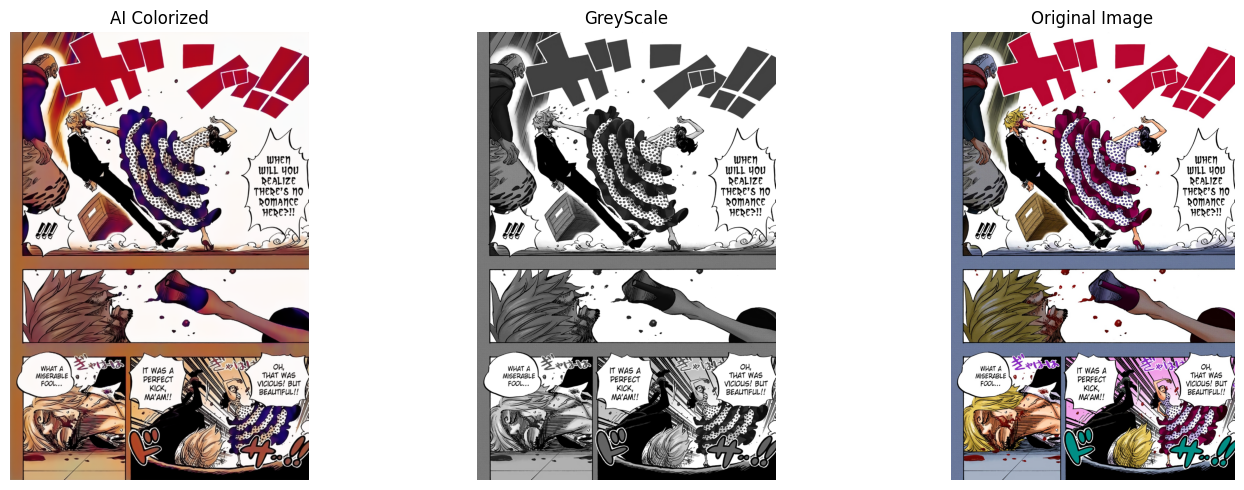

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Remplace ces chemins par les liens de tes images
image1_path = "/content/colored_manga/results/colorized/2.png"
image2_path = "/content/colored_manga/results/grayscale/2.png"
image3_path = "/content/colored_manga/results/original/2.png"

# Charger les images
image1 = mpimg.imread(image1_path)
image2 = mpimg.imread(image2_path)
image3 = mpimg.imread(image3_path)

# Créer les subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Afficher les images
axes[0].imshow(image1)
axes[0].axis('off')  # Désactiver les axes
axes[0].set_title("AI Colorized")

axes[1].imshow(image2, cmap='gray')
axes[1].axis('off')
axes[1].set_title("GreyScale")

axes[2].imshow(image3)
axes[2].axis('off')
axes[2].set_title("Original Image")

# Afficher la figure
plt.tight_layout()
plt.show()